In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
# Set directory as default system path
import sys
sys.path.append('/content/drive/MyDrive/smart-pixels')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import keras
import pandas as pd
import numpy as np
from global_vars import * 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from models import MultiOutputRegModel
from custom_callbacks import CustomCallback
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, BatchNormalization, Flatten, Dropout
from keras.models import Model
import seaborn as sns
import matplotlib.pyplot as plt

Num GPUs Available:  1


In [ ]:
class DataGenerator:
    
    def __init__(self, nsamples, drop_cols = None):
        self.n = nsamples
        df1 = pd.read_csv(CLUSTERS_FILE)
        df2 = pd.read_csv(LABELS_FILE)
        
        self.X = df1.values
        n = self.X.shape[0]
        self.X = np.reshape(self.X, (n,13,21,1))
        
        if drop_cols != None:
            df2.drop(drop_cols, axis=1, inplace=True)
            
        print(df2.head())
        self.y = df2

        # scale all outputs to homogenize output

        self.y['x-entry'] = self.y['x-entry']/1000.
        self.y['y-entry'] = self.y['y-entry']/100.
        # self.y['cotAlpha'] = self.y['cotAlpha']/10.

        print(self.y.head())
     
    def get_train_test_split(self, test_size = 0.2, seed = 0):
        X_train, X_test, y_train, y_test = train_test_split(self.X,
                                                            self.y,
                                                            test_size = test_size, 
                                                            random_state = seed)
        print(self.X.shape, self.y.shape)
        print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

        #scale input data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
        X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

        x_entry_train, x_entry_test = np.array(y_train['x-entry']),np.array(y_test['x-entry'])
        y_entry_train, y_entry_test = np.array(y_train['y-entry']),np.array(y_test['y-entry'])
        cotAlpha_train, cotAlpha_test = np.array(y_train['cotAlpha']),np.array(y_test['cotAlpha'])
        cotBeta_train, cotBeta_test = np.array(y_train['cotBeta']),np.array(y_test['cotBeta'])
        
        trainY = (x_entry_train, y_entry_train, cotAlpha_train, cotBeta_train)
        testY = (x_entry_test, y_entry_test, cotAlpha_test, cotBeta_test)

        # trainY = (np.column_stack([x_entry_train, y_entry_train]), np.column_stack([cotAlpha_train, cotBeta_train]))
        # testY = (np.column_stack([x_entry_test, y_entry_test]), np.column_stack([cotAlpha_test, cotBeta_test]))

        return X_train, X_test, trainY, testY

In [ ]:
datagen = DataGenerator(nsamples= NEVENTS, 
                        drop_cols = ['n_x','n_y','n_z','number_eh_pairs','z-entry'])
X_train, X_test, trainY, testY = datagen.get_train_test_split(test_size = 0.20,  seed = 0)

      x-entry    y-entry  cotAlpha   cotBeta
0 -168.364151  -2.262124  3.696619  0.098554
1 -127.467667  15.197241  2.341443 -0.206051
2 -369.492645  -0.128008  7.428552 -0.017690
3 -365.951111  -4.567823  7.807505  0.044182
4 -200.628601  14.304100  3.911512 -0.191527
    x-entry   y-entry  cotAlpha   cotBeta
0 -0.168364 -0.022621  3.696619  0.098554
1 -0.127468  0.151972  2.341443 -0.206051
2 -0.369493 -0.001280  7.428552 -0.017690
3 -0.365951 -0.045678  7.807505  0.044182
4 -0.200629  0.143041  3.911512 -0.191527
(650000, 13, 21, 1) (650000, 4)
(520000, 13, 21, 1) (130000, 13, 21, 1) (520000, 4) (130000, 4)


In [ ]:
# class BranchedRegModel1:

#     def build_default_hidden_layers(self, inputs):
#         x = Conv2D ( filters = 8 , kernel_size = (3 , 3) , strides = (1 , 1) ,
#                          activation = "relu" , name = "conv_1" ) ( inputs )
#         x = Conv2D ( filters = 16 , kernel_size = (3 , 3) , strides = (1 , 1) ,
#                          activation = "relu" , name = "conv_2" ) ( x )
#         x = MaxPooling2D ( (2 , 2) , name = "maxpool_1" ) ( x )
#         x = Conv2D ( filters = 32 , kernel_size = (3 , 3) , strides = (1 , 1) ,
#                          activation = "relu" , name = "conv_3" ) ( x )
#         x = MaxPooling2D ( (2 , 2) , name = "maxpool_2" ) ( x )

#         return x

#     def build_coords_branch(self,inputs):

#         x = Flatten()(inputs)
#         x = Dense(64, activation = "relu")(x)
#         x = BatchNormalization ( ) ( x )
#         x = Dense(32, activation = "relu")(x)
#         x = BatchNormalization ( ) ( x )
#         x = Dropout ( 0.1 ) ( x )
#         x = Dense ( 2, activation = "linear", name = "coords_output" ) ( x )
#         return x

#     def build_angles_branch(self,inputs):
#         x = Flatten()(inputs)
#         x = Dense ( 32 , activation =  "relu") ( x )
#         x = BatchNormalization ( ) ( x )
#         x = Dropout ( 0.1 ) ( x )
#         x = Dense ( 1, activation = "linear", name = "angles_output" ) ( x )
#         return x

#     def assemble_full_model(self,inputs_shape):
#         inputs = Input ( shape = inputs_shape )
#         common_branch_inputs = self.build_default_hidden_layers ( inputs )
#         coords_output = self.build_coords_branch(common_branch_inputs)
#         angles_output = self.build_angles_branch(common_branch_inputs)
#         # output = concatenate ( [x_output, y_output,alpha_output ,beta_output] , name = "total_output")
#         model = Model ( inputs = inputs ,
#                         outputs = [coords_output, angles_output],
#                         name = "model_1" )
#         model.summary()
#         return model

In [ ]:
class BranchedRegModel2:

    def build_default_hidden_layers(self, inputs):
        x = Conv2D ( filters = 8 , kernel_size = (3 , 3) , strides = (1 , 1) ,
                         activation = "relu" , name = "conv_1" ) ( inputs )
        x = Conv2D ( filters = 16 , kernel_size = (3 , 3) , strides = (1 , 1) ,
                         activation = "relu" , name = "conv_2" ) ( x )
        x = MaxPooling2D ( (2 , 2) , name = "maxpool_1" ) ( x )
        x = Conv2D ( filters = 32 , kernel_size = (3 , 3) , strides = (1 , 1) ,
                         activation = "relu" , name = "conv_3" ) ( x )
        x = MaxPooling2D ( (2 , 2) , name = "maxpool_2" ) ( x )

        return x

    def build_x_branch(self,inputs):

        x = Flatten()(inputs)
        x = Dense(64, activation = "relu")(x)
        x = BatchNormalization ( ) ( x )
        x = Dense(32, activation = "relu")(x)
        x = BatchNormalization ( ) ( x )
        x = Dropout ( 0.2 ) ( x )
        x = Dense ( 1, activation = "linear", name = "x_output" ) ( x )
        return x

    def build_y_branch(self,inputs):

        x = Flatten()(inputs)
        x = Dense(16, activation = "relu")(x)
        x = BatchNormalization ( ) ( x )
        x = Dense(8, activation = "relu")(x)
        x = BatchNormalization ( ) ( x )
        x = Dropout ( 0.05 ) ( x )
        x = Dense ( 1, activation = "linear", name = "y_output" ) ( x )
        return x

    def build_cotAlpha_branch(self,inputs):
        x = Flatten()(inputs)
        x = Dense ( 32 , activation =  "relu") ( x )
        x = BatchNormalization ( ) ( x )
        x = Dropout ( 0.1 ) ( x )
        x = Dense ( 1, activation = "linear", name = "alpha_output" ) ( x )
        return x

    def build_cotBeta_branch(self,inputs):
        x = Flatten()(inputs)
        x = Dense ( 16 , activation =  "relu") ( x )
        x = BatchNormalization ( ) ( x )
        x = Dropout ( 0.05 ) ( x )
        x = Dense ( 1, activation = "linear", name = "beta_output" ) ( x )
        return x

    def assemble_full_model(self,inputs_shape):
        inputs = Input ( shape = inputs_shape )
        common_branch_inputs = self.build_default_hidden_layers ( inputs )
        x_output = self.build_x_branch(common_branch_inputs)
        y_output = self.build_y_branch(common_branch_inputs)
        alpha_output = self.build_cotAlpha_branch(common_branch_inputs)
        beta_output = self.build_cotBeta_branch(common_branch_inputs)
        # output = concatenate ( [x_output, y_output,alpha_output ,beta_output] , name = "total_output")
        model = Model ( inputs = inputs ,
                        outputs = [x_output, y_output,alpha_output,beta_output],
                        name = "model_2" )
        model.summary()
        return model

In [ ]:
model = BranchedRegModel2().assemble_full_model(inputs_shape=(13,21,1))

checkpoint_path = "./models/multi_output_model_cp.ckpt"

# Create a callback that saves the model's weights 
# currently, model weights are saved for each training
# to do - update for early stopping
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              save_weights_only=True,
                              verbose=1,
                              save_best_only = True)

csv_logger = CSVLogger('log.csv', append=True, separator=';')
es = EarlyStopping(monitor = "val_loss",patience=10, min_delta = 1e-5,mode="min")
batch_size = 64
init_lr = 0.05
epochs = 50
opt = Adam(lr=init_lr, decay=init_lr / epochs)

model.compile(loss = {'x_output': 'mse',
                      'y_output': 'mse',
                      'alpha_output': 'mse',
                      'beta_output': 'mse'},
              optimizer=opt,  
              metrics= {'x_output': MeanSquaredError(),
                      'y_output': MeanSquaredError(),
                      'alpha_output': MeanSquaredError(),
                      'beta_output': MeanSquaredError()},
              # loss_weights= {'x_output': 1. ,
              #               'y_output': 0.5,
              #               'alpha_output': 1. ,
              #               'beta_output': 0.5}       
             )

history = model.fit(
          X_train, trainY,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, testY),
          callbacks=[cp_callback, csv_logger, es],
          )

In [ ]:
res = model.evaluate(
    X_test, testY, batch_size=batch_size,
)

predictions = model.predict(X_test, batch_size=batch_size, callbacks=[CustomCallback()])
print(len(predictions))
preds = np.concatenate(predictions,axis = 1)
truths = np.column_stack(testY)
df_predict = pd.DataFrame(preds, columns=['x-entry', 'y-entry', 'cotAlpha', 'cotBeta'])
trueLabels = pd.DataFrame(truths, columns=['x-entry', 'y-entry', 'cotAlpha', 'cotBeta'])

2032/2032 [==============================] - 7s 4ms/step - loss: 0.0120 - x_output_loss: 4.4089e-05 - y_output_loss: 2.0860e-04 - alpha_output_loss: 0.0110 - beta_output_loss: 7.9664e-04 - x_output_mean_squared_error: 4.4083e-05 - y_output_mean_squared_error: 2.0859e-04 - alpha_output_mean_squared_error: 0.0110 - beta_output_mean_squared_error: 7.9702e-04
Start predicting; got log keys: []
Stop predicting; got log keys: []
4


In [ ]:
# rescale
df_predict['x-entry'] = 1000.* df_predict['x-entry']
trueLabels['x-entry'] = 1000.* trueLabels['x-entry']

df_predict['y-entry'] = 100.* df_predict['y-entry']
trueLabels['y-entry'] = 100.* trueLabels['y-entry']

In [ ]:
def calc_residuals(y, y_pred):
    res = y - y_pred
    return np.mean(res), np.std(res)

res = []
for col in df_predict.columns:
    mean,sd = calc_residuals(trueLabels[col],df_predict[col])
    res.append([col, mean, sd])

In [ ]:
pd.DataFrame(res, columns = ["variable","mean", "std"], index = None)

,variable,mean,std
0,x-entry,-0.941694,7.413845
1,y-entry,0.084184,1.413741
2,cotAlpha,0.057075,0.117815
3,cotBeta,-0.000211,0.025784


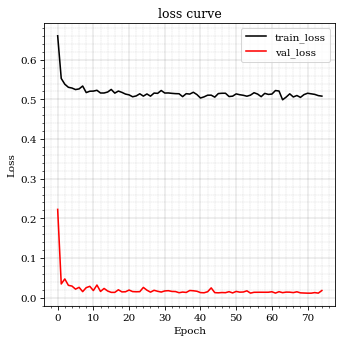

In [ ]:
plt.rcParams['font.family'] = [u'serif']
plt.rcParams['legend.title_fontsize'] = 'xx-small'
fig = plt.figure(figsize = (5,5), dpi = 75)
plt.plot(history.history['loss'], label='train_loss', color = "black")
plt.plot(history.history['val_loss'], label = 'val_loss', color = "red")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.25', alpha=0.5,color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.25', alpha=0.5,color='black')
plt.title("loss curve")
plt.show()

In [ ]:
# def saving_model(model,
#                  filepath:str ='',
#                  model_filename:str ='model'):
#     """
#     Helper function to save the trained pruned models in the following format:
#         Config -> JSON file format
#         Weights -> H5PY file format
#     :param model: Keras Model object
#     :param filepath: path to store the file in the directory
#     :param model_filename: name for the model
#     :return: None
#     """ 
#     # serialize model to JSON
#     model_json = model.to_json()
#     with open(filepath + "/" + model_filename + ".json", "w") as json_file:
#         json_file.write(model_json)
#     # serialize weights to HDF5
#     model.save_weights(filepath + "/" + model_filename + "_weights.h5")
#     print("Saved model to disk")

In [ ]:
# saving_model(model, filepath = sys.path[-1] + "/" + "models", model_filename = "BRM_02")

In [ ]:
sns.scatterplot(x = trueLabels['cotBeta'], y = trueLabels['cotBeta'] - df_predict['cotBeta'])
plt.show()

In [ ]:
from scipy.stats import pearsonr
pearsonr(x = trueLabels['cotAlpha'], y =trueLabels['cotAlpha'] - df_predict['cotAlpha'])